In [1]:
from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random

In [2]:
with open('log.txt', 'r') as f:
    data = f.read().splitlines()

In [3]:
columns = ['slot', 'userID', 'ts', 'browser', 'all_cl']
data = pd.read_csv('log.txt', sep='\t', names=columns)

for column in columns:
    data[column] = data[column].apply(lambda x: x.split('=')[1])
data['browser'] = data['browser'].apply(lambda x: x.split('#')[1])

In [4]:
data['userID'] = data['userID'].apply(lambda x: int(x))
data['browser'] = data['browser'].apply(lambda x: int(x))
data['all_cl'] = data['all_cl'].apply(lambda x: int(x))

In [5]:
data.head()

,slot,userID,ts,browser,all_cl
0,exp,1,2016-03-03,2,1
1,exp,1,2016-03-03,2,5
2,exp,1,2016-03-03,2,1
3,exp,1,2016-03-03,2,1
4,exp,1,2016-03-03,2,6


### 1 задание. (6 баллов)
Посчитайте метрику "Общее количество кликов" для эксперимента и контроля. (уточнение: "Общее количество кликов" - это просто сумма всех кликов, то есть сумма всех чисел в колонке "число кликов на данном запросе").
Найдите уровень значимости (p-value) того, что "Общее количество кликов" в контроле и эксперименте различается.
Обоснуйте валидность и применимость метода, которым посчитано p-value.

In [6]:
clickExp = data[data['slot'] == 'exp']['all_cl'].values
clickControl = data[data['slot'] == 'control']['all_cl'].values

In [7]:
clickCountExp = clickExp.sum()
clickCountControl = clickControl.sum()

"Кол-во кликов в эксперименте: {}, кол-во кликов на контроле: {}".format(clickCountExp, clickCountControl)

'Кол-во кликов в эксперименте: 3261823, кол-во кликов на контроле: 3210027'

In [8]:
"Разность кол-ва кликов на эксперименте и контроле: {}".format(clickCountExp - clickCountControl)

'Разность кол-ва кликов на эксперименте и контроле: 51796'

In [9]:
nExp = len(data[data['slot'] == 'exp']['all_cl'])
nControl = len(data[data['slot'] == 'control']['all_cl'])
nExp, nControl

(2982437, 3086816)

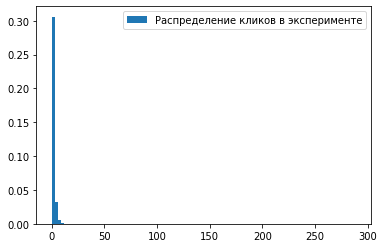

In [10]:
plt.hist(clickExp, bins=100, label="Распределение кликов в эксперименте", density=True)
plt.legend()
plt.show()

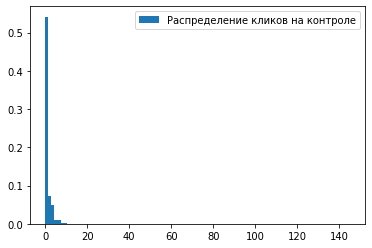

In [11]:
plt.hist(clickControl, bins=100, label="Распределение кликов на контроле", density=True)
plt.legend()
plt.show()

Нахождение корреляции между данными:

In [12]:
random.shuffle(clickControl)
chosenClickControl = clickControl[:nExp]
stats.spearmanr(chosenClickControl, clickExp)

SpearmanrResult(correlation=-0.00048098737517538826, pvalue=0.406170201629966)

Корреляция между кликами в контрольной и экспериментальной выборках близка к 0. Значение p-value > 0.1, поэтому ничего определенного сказать про результат нельзя: так как нулевая гипотеза о том, что эти две выборки некоррелированы, может быть как верна, так и не верна, но мощность критерия недостаточна.  
  
Однако далее в своих рассуждения буду использовать предположение, что эти две выборки некоррелированы (потому что корреляционная зависимость близка к 0).

In [13]:
meanExp = clickExp.mean()
meanControl = clickControl.mean()
meanExp, meanControl

(1.0936770835394007, 1.0399152395218891)

In [14]:
varExp = sum([(click - meanExp) ** 2 for click in clickExp]) / (nExp - 1)
varControl = sum([(click - meanControl) ** 2 for click in clickControl]) / (nControl - 1)
varExp, varControl

(2.8430142120689648, 2.674248052988124)

In [15]:
stats.ttest_ind(clickExp, clickControl, equal_var=False)

Ttest_indResult(statistic=39.855340710919414, pvalue=0.0)

p-value < 0.1, поэтому гипотеза о том, что выборки кликов на контроле и эксперименте имеют одинаковое среднее, отклоняется.

In [16]:
B = 50

In [17]:
bootsExp = np.random.choice(clickExp, (nExp, B), replace=True)
bootsControl = np.random.choice(clickControl, (nControl, B), replace=True)

In [18]:
bootsExp.shape

(2982437, 50)

In [19]:
bootsSumExp = bootsExp.sum(axis=0)
bootsSumExp.shape

(50,)

In [20]:
bootsSumControl = bootsControl.sum(axis=0)
bootsSumControl.shape

(50,)

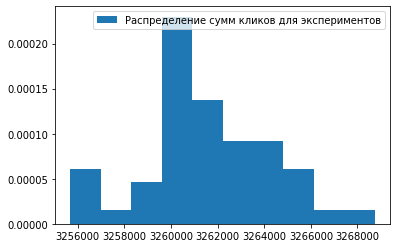

In [21]:
plt.hist(bootsSumExp, density=True, label="Распределение сумм кликов для экспериментов")
plt.legend()
plt.show()

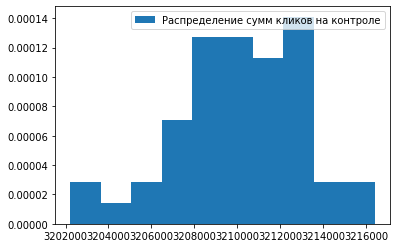

In [22]:
plt.hist(bootsSumControl, density=True, label="Распределение сумм кликов на контроле")
plt.legend()
plt.show()

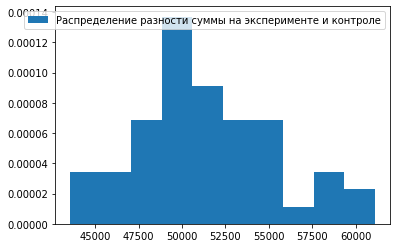

In [23]:
plt.hist(bootsSumExp - bootsSumControl, density=True, label="Распределение разности суммы на эксперименте и контроле")
plt.legend()
plt.show()

#### Тест Шапиро-Уилка на нормальность выборки

In [24]:
stats.shapiro(bootsSumExp - bootsSumControl)

(0.9780904650688171, 0.474545955657959)

In [25]:
stats.shapiro(bootsSumExp)

(0.9740822911262512, 0.3364599943161011)

In [26]:
stats.shapiro(bootsSumControl)

(0.9801156520843506, 0.5568515062332153)

По результатам теста Шапиро-Уилка на нормальность нельзя отклонить гипотезу, что выборки сумм на эксперименте, контроле и их разности являются не нормальными.

In [27]:
bootsMeanExp = bootsSumExp.mean()
bootsMeanControl = bootsSumControl.mean()
"Бутстрапированное среднее суммы кликов для эксперимента: {}, для контроля: {}".format(bootsMeanExp, bootsMeanControl)

'Бутстрапированное среднее суммы кликов для эксперимента: 3261587.94, для контроля: 3210070.44'

In [28]:
"Разность бутстрапированного среднего суммы кликов для эксперимента и контроля: {}".format(bootsMeanExp - bootsMeanControl)

'Разность бутстрапированного среднего суммы кликов для эксперимента и контроля: 51517.5'

In [29]:
bootsVarianceExp = np.mean([(clickSum - bootsMeanExp) ** 2 for clickSum in bootsSumExp])
bootsVarianceControl = np.mean([(clickSum - bootsMeanControl) ** 2 for clickSum in bootsSumControl])
"Бутстрапированная дисперсия суммы кликов для эксперимента: {}, для контроля: {}".format(bootsVarianceExp, bootsVarianceControl)

'Бутстрапированная дисперсия суммы кликов для эксперимента: 7283649.256400001, для контроля: 8423956.886400001'

In [30]:
stats.ttest_ind(bootsSumExp, bootsSumControl, equal_var=False)

Ttest_indResult(statistic=90.99087015015198, pvalue=4.29559328817261e-96)

p-value < 0.1, поэтому отклоняется гипотеза о том, что общее количество кликов в контроле и эксперименте совпадает. Следовательно, кликабельность изменилась. Было показано, что она выросла в эксперименте.

Значение p-value было посчитано следующим образом:  
1) так как у нас есть только одна выборка и по ней нужно считать сумму кликов, то было сгенерировано с помощью бутсрепа 50 выборок (50 экспериментальных и 50 контрольных), по которым оценивались суммы кликов  

2)Использование T-теста основывается на следующих условиях: 
- с помощью теста Шапиро-Уилка было показано, что распределение выборок суммы на эксперименте и контроле может быть нормальным  
- можно сделать предположение, что внутри каждой из выборок все элементы независимы  
- выборки независимы друг от друга, так как исходные выборки независимы друг от друга 

In [31]:
stats.mannwhitneyu(bootsSumExp, bootsSumControl)

MannwhitneyuResult(statistic=0.0, pvalue=3.532239206713374e-18)

Если вместо T-теста использовать U-критерий Манна-Уитни (справедлив при условиях 2-3 Т-теста + выборки должны быть из одинакового распределения (с точностью до сдвига)), получаем, что различия между значениями количества кликов в выборках достоверны, так как значение критерия мало.

### 2 задание. (6 баллов)
Локализуется ли изменение кликов в каком-либо срезе?
Является ли этот срез единственным?

In [32]:
B = 100

def getSlice(column, sliceValues):
    df = pd.DataFrame(columns=[column, 'all_cl', 'exp_cl', 'control_cl', 'exp_cl - control_cl'])
    for i, slice_ in enumerate(sliceValues):
        print("{}: {}".format(column, slice_))
        clickBySlice = data[data[column] == slice_]
        experimentData = clickBySlice[clickBySlice['slot'] == 'exp']['all_cl'].values
        controlData = clickBySlice[clickBySlice['slot'] == 'control']['all_cl'].values
        
        expSum = sum(experimentData)
        controlSum = sum(controlData)
        clickSum = expSum + controlSum
        df.loc[i] = [slice_, clickSum, expSum, controlSum, expSum - controlSum]
        
        bExp = np.random.choice(experimentData, (len(experimentData), B), replace=True)
        bControl = np.random.choice(controlData, (len(controlData), B), replace=True)

        bSumExp = bExp.sum(axis=0)
        bSumControl = bControl.sum(axis=0)

        print("Тест Шапиро-Уилкса на нормальность:")
        print("\t эксперимент: ", stats.shapiro(bSumExp))
        print("\t контроль: ", stats.shapiro(bSumControl))

        bMeanExp = bSumExp.mean()
        bMeanControl = bSumControl.mean()
        print("Бутстрапированное среднее суммы кликов для эксперимента: {}, для контроля: {}".format(bMeanExp, bMeanControl))
        print("Среднее бутстрапированных разностей суммы кликов для эксперимента и контроля: {}".format(np.mean(bSumExp - bSumControl)))

        bVarianceExp = np.mean([(clickSum - bMeanExp) ** 2 for clickSum in bSumExp])
        bVarianceControl = np.mean([(clickSum - bMeanControl) ** 2 for clickSum in bSumControl])
        print("Бутстрапированная дисперсия суммы кликов для эксперимента: {}, для контроля: {}".format(bVarianceExp, bVarianceControl))
        if stats.shapiro(bSumExp)[1] > 0.1 and stats.shapiro(bSumControl)[1] > 0.1:
            print(stats.ttest_ind(bSumExp, bSumControl, equal_var=False))
        print("____________________________________________________________")
    return df

In [33]:
timestamps = np.unique(data['ts'].values)
timestamps

array(['2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
       '2016-03-01', '2016-03-02', '2016-03-03'], dtype=object)

In [34]:
df1 = getSlice('ts', timestamps)

ts: 2016-02-26
Тест Шапиро-Уилкса на нормальность:
	 эксперимент:  (0.9942685961723328, 0.9515268206596375)
	 контроль:  (0.9924747943878174, 0.8544660806655884)
Бутстрапированное среднее суммы кликов для эксперимента: 496438.44, для контроля: 488279.61
Среднее бутстрапированных разностей суммы кликов для эксперимента и контроля: 8158.83
Бутстрапированная дисперсия суммы кликов для эксперимента: 938012.6064, для контроля: 860286.7379000001
Ttest_indResult(statistic=60.536106981403215, pvalue=1.5684356064624515e-129)
____________________________________________________________
ts: 2016-02-27
Тест Шапиро-Уилкса на нормальность:
	 эксперимент:  (0.988175630569458, 0.5212441086769104)
	 контроль:  (0.9783239960670471, 0.09832648187875748)
Бутстрапированное среднее суммы кликов для эксперимента: 495793.63, для контроля: 488660.22
Среднее бутстрапированных разностей суммы кликов для эксперимента и контроля: 7133.41
Бутстрапированная дисперсия суммы кликов для эксперимента: 753073.1331000002,

p-value < 0.1, поэтому гипотеза, что  кликабельность не изменилась, отклоняется для каждого исследуемого дня.

In [35]:
df1

,ts,all_cl,exp_cl,control_cl,exp_cl - control_cl
0,2016-02-26,984654,496413,488241,8172
1,2016-02-27,984559,495785,488774,7011
2,2016-02-28,1059587,531376,528211,3165
3,2016-02-29,825180,416926,408254,8672
4,2016-03-01,512616,257483,255133,2350
5,2016-03-02,1018349,513442,504907,8535
6,2016-03-03,1086905,550398,536507,13891


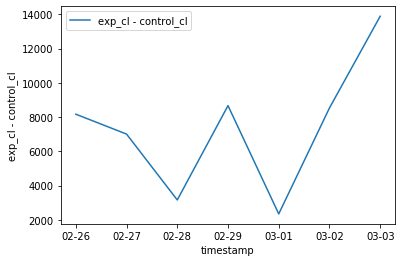

In [36]:
plt.plot(df1['ts'].apply(lambda x: x[5:]), df1['exp_cl - control_cl'].values, label="exp_cl - control_cl")
plt.xlabel('timestamp')
plt.ylabel('exp_cl - control_cl')
plt.legend()
plt.show()

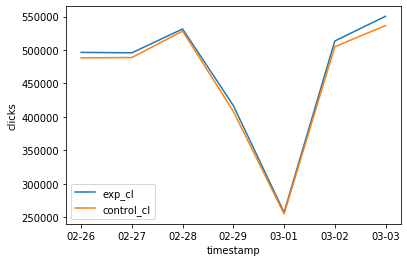

In [37]:
plt.plot(df1['ts'].apply(lambda x: x[5:]), df1['exp_cl'].values, label="exp_cl")
plt.plot(df1['control_cl'].values, label="control_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

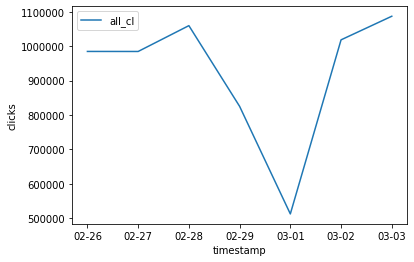

In [38]:
plt.plot(df1['ts'].apply(lambda x: x[5:]), df1['all_cl'].values, label="all_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

**Вывод:**  
1) После разбиения выборки по дате видно, что разность между суммой кликов в экспериментальной и контрольной выборках имеет тенденцию к увеличению. Следовательно, некоторые изменения повликли за собой увеличение суммы кликов на эксперименте  
2) 1 марта 2016 характерен минимум по сумме кликов за дни эксперимента, причем очень резкий. Это был вторник. 29 февраля (понедельник) количество запросов тоже снизилось. Можно предположить, что из-за рабочих дней произошло снижение пользовательской активности.  

Немного пояндексоидив, я не нашла каких-то значимых новостей за данный промежуток времени, поэтому пока предположим, что снижение, а затем рост числа кликов произошел из-за работы какого-либо сервиса.

In [39]:
browsers = np.unique(data['browser'].values)
browsers

array([ 2,  4, 14, 17, 20, 22])

In [40]:
df2 = getSlice('browser', browsers)

browser: 2
Тест Шапиро-Уилкса на нормальность:
	 эксперимент:  (0.984820544719696, 0.3082464039325714)
	 контроль:  (0.9923025965690613, 0.8426903486251831)
Бутстрапированное среднее суммы кликов для эксперимента: 559932.66, для контроля: 566002.68
Среднее бутстрапированных разностей суммы кликов для эксперимента и контроля: -6070.02
Бутстрапированная дисперсия суммы кликов для эксперимента: 1472668.3643999996, для контроля: 1421915.9375999996
Ttest_indResult(statistic=-35.49887729625873, pvalue=8.95919002379466e-88)
____________________________________________________________
browser: 4
Тест Шапиро-Уилкса на нормальность:
	 эксперимент:  (0.9937955737113953, 0.931082546710968)
	 контроль:  (0.986260712146759, 0.3898579478263855)
Бутстрапированное среднее суммы кликов для эксперимента: 1058901.6, для контроля: 1064396.84
Среднее бутстрапированных разностей суммы кликов для эксперимента и контроля: -5495.24
Бутстрапированная дисперсия суммы кликов для эксперимента: 3242349.78, для контр

In [41]:
df2

,browser,all_cl,exp_cl,control_cl,exp_cl - control_cl
0,2,1126073,560109,565964,-5855
1,4,2123390,1058995,1064395,-5400
2,14,501785,294556,207229,87327
3,17,533017,266285,266732,-447
4,20,449109,223212,225897,-2685
5,22,1738476,858666,879810,-21144


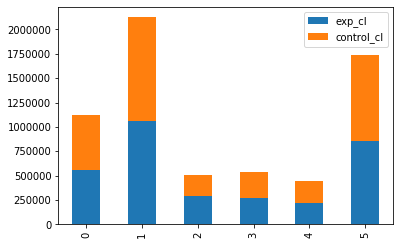

In [42]:
df2[['exp_cl', 'control_cl']].plot.bar(stacked=True)

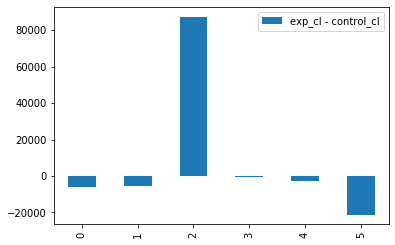

In [43]:
df2[['exp_cl - control_cl']].plot.bar(stacked=True)

**Вывод:**  
Если сделать срез по браузерам, видно, что аномальные значения по количеству кликов связаны с браузерами под номерами 4 и 22. Но это может быть обосновано, если люди, например, чаще пользуются мобильной версией браузера, так как в 2016 году уже были развиты технологии. Поэтому были рассмотрены разности сумм кликов на экспериментальной и контрольной выборках, чтобы попробовать уловить изменения.  
  
Видно, что число кликов на экспериментальной выборке выросло по сравнению с контрольной почти на 88 000 запросов в браузере под номером 14, однако во всех остальных браузерах различия не были столь большими (поэтому можно попробовать сделать вывод, что пользователи чаще пользуются браузерами 4 и 22 и из-за этого такие большие значения суммы кликов). Если разность кликов в браузерах под номерами 2, 4, 17, 20 можно списать на обычные изменения пользовательской активности, то в браузере 22 такого сделать нельзя, слишком уж велико число. Следовательно, в браузере 22 уменьшилась кликабельность в эксперименте.

In [44]:
df3 = pd.DataFrame(columns=['ts', 'browser', 'all_cl', 'exp_cl', 'control_cl', 'exp_cl - control_cl'])
rowIdx=0
for ts in timestamps:
    dataByTS = data[data['ts'] == ts]
    for browser in browsers:
        dataByTSAndBrowser = dataByTS[dataByTS['browser'] == browser]
        
        experimentData = dataByTSAndBrowser[dataByTSAndBrowser['slot'] == 'exp']['all_cl'].values
        controlData = dataByTSAndBrowser[dataByTSAndBrowser['slot'] == 'control']['all_cl'].values
        
        expSum = sum(experimentData)
        controlSum = sum(controlData)
        clickSum = expSum + controlSum
        df3.loc[rowIdx] = [ts, browser, clickSum, expSum, controlSum, expSum - controlSum]
        rowIdx += 1

In [45]:
df3

,ts,browser,all_cl,exp_cl,control_cl,exp_cl - control_cl
0,2016-02-26,2,171183,84677,86506,-1829
1,2016-02-26,4,322896,161945,160951,994
2,2016-02-26,14,74885,44056,30829,13227
3,2016-02-26,17,81531,41022,40509,513
4,2016-02-26,20,69238,34708,34530,178
5,2016-02-26,22,264921,130005,134916,-4911
6,2016-02-27,2,175275,86624,88651,-2027
7,2016-02-27,4,318660,159029,159631,-602
8,2016-02-27,14,76654,44705,31949,12756
9,2016-02-27,17,79168,39798,39370,428


In [46]:
df4 = df3[df3['browser'] == 14]
df4

,ts,browser,all_cl,exp_cl,control_cl,exp_cl - control_cl
2,2016-02-26,14,74885,44056,30829,13227
8,2016-02-27,14,76654,44705,31949,12756
14,2016-02-28,14,85227,49206,36021,13185
20,2016-02-29,14,64370,38301,26069,12232
26,2016-03-01,14,39408,23254,16154,7100
32,2016-03-02,14,77631,45360,32271,13089
38,2016-03-03,14,83610,49674,33936,15738


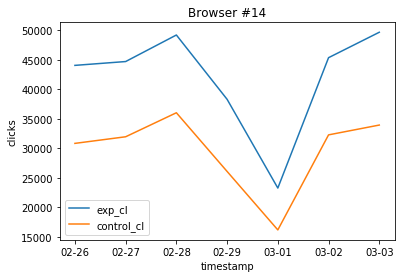

In [47]:
plt.title('Browser #14')
plt.plot(df4['ts'].apply(lambda x: x[5:]), df4['exp_cl'].values, label="exp_cl")
plt.plot(df4['control_cl'].values, label="control_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

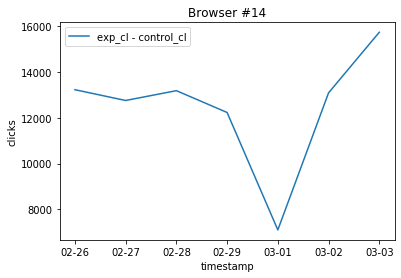

In [48]:
plt.title('Browser #14')
plt.plot(df4['ts'].apply(lambda x: x[5:]), df4['exp_cl - control_cl'].values, label="exp_cl - control_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

In [49]:
df5 = df3[df3['browser'] == 22]
df5

,ts,browser,all_cl,exp_cl,control_cl,exp_cl - control_cl
5,2016-02-26,22,264921,130005,134916,-4911
11,2016-02-27,22,267480,132092,135388,-3296
17,2016-02-28,22,287398,141733,145665,-3932
23,2016-02-29,22,219821,108344,111477,-3133
29,2016-03-01,22,136495,67274,69221,-1947
35,2016-03-02,22,272061,134318,137743,-3425
41,2016-03-03,22,290300,144900,145400,-500


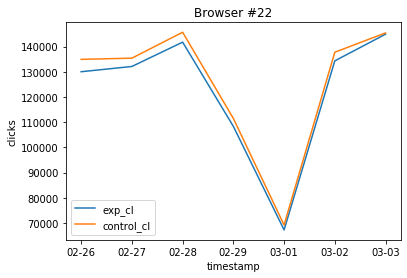

In [50]:
plt.title('Browser #22')
plt.plot(df5['ts'].apply(lambda x: x[5:]), df5['exp_cl'].values, label="exp_cl")
plt.plot(df5['control_cl'].values, label="control_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

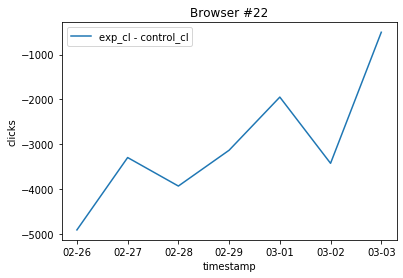

In [51]:
plt.title('Browser #22')
plt.plot(df5['ts'].apply(lambda x: x[5:]), df5['exp_cl - control_cl'].values, label="exp_cl - control_cl")
plt.xlabel('timestamp')
plt.ylabel('clicks')
plt.legend()
plt.show()

**Вывод:**  
У браузера 14 наблюдается минимум 1 марта по числу кликов, но потом оно растет. Можно предположить, что была некоторая ошибка или пользователям не нравились изменения и количество кликов уменьшилось по этим причинам, после данная проблема была устранена и кол-во кликов вернулось на прошлый уровень, либо же появились мгновенные ответы, позволяющие видеть сразу ответ.  
  
Кликов в браузере 22  на эксперименте меньше, чем на контроле, но с каждым днём есть тенденция к увеличению разности между суммами кликов. Было бы неплохо иметь данные ещё и за следующие дни, чтобы дать более точный ответ на то, что происходит с ними, но в рамках этих данных можно сказать, что пользователи стали меньше кликать на эксперименте (возможно, что изменился интерфейс и он стал более удобным (например, внедрение различных каруселей, поисковых подсказок и т.д.)), но пока не очевидно с чем связан рост разности между кликами.

In [52]:
x_ts_label = [ts[5:] for ts in timestamps]

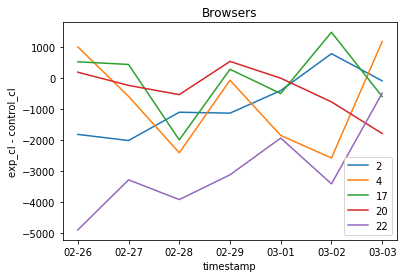

In [53]:
plt.title('Browsers')
plt.plot(x_ts_label, df3[df3['browser'] == 2]['exp_cl - control_cl'].values, label="2")
plt.plot(x_ts_label, df3[df3['browser'] == 4]['exp_cl - control_cl'].values, label="4")
plt.plot(x_ts_label, df3[df3['browser'] == 17]['exp_cl - control_cl'].values, label="17")
plt.plot(x_ts_label, df3[df3['browser'] == 20]['exp_cl - control_cl'].values, label="20")
plt.plot(x_ts_label, df3[df3['browser'] == 22]['exp_cl - control_cl'].values, label="22")
plt.xlabel('timestamp')
plt.ylabel('exp_cl - control_cl')
plt.legend()
plt.show()

На всех браузерах (кроме 14) метрика суммы кликов за день "просела"

Изменение кликов локализуется в браузерах 14 и 22. 

### 3 задание. (8 баллов)
Можно ли по предложенным данным предположить, положительный эффект имело экспериментальное изменение, или отрицательный? Необходимо дать развернутый ответ, для этого:  
- Попробуйте построить гипотезы, по какой причине вообще могла измениться метрика "Общее количество кликов".  
- Попробуйте проанализировать поведение различных метрик (Например, количество кликов, количество запросов, Clickthrough rate (CTR), доля некликнутых запросов, количество uid-ов, ...).  
- Попробуйте посмотреть различные срезы и сравнить их между собой.  
Изучите полученные данные на наличие аномалий в контроле или эксперименте. Если аномалии есть, то попробуйте объяснить их причину.

In [54]:
df6 = pd.DataFrame(columns=['ts', 'кол-во userID'])
rowIdx=0
for ts in timestamps:
    dataByTS = data[data['ts'] == ts]
    uidCount = len(np.unique(dataByTS['userID'].values))
    df6.loc[rowIdx] = [ts, uidCount]
    rowIdx += 1
df6

,ts,кол-во userID
0,2016-02-26,224006
1,2016-02-27,220793
2,2016-02-28,225347
3,2016-02-29,233900
4,2016-03-01,232953
5,2016-03-02,228821
6,2016-03-03,228497


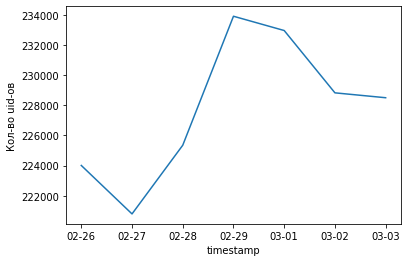

In [55]:
plt.xlabel('timestamp')
plt.ylabel('Кол-во uid-ов')
plt.plot(x_ts_label, df6['кол-во userID'].values)
plt.show()

Увеличением количества пользователей после 27 февраля можно объяснить рост разности между суммой кликов, но до сих пор нельзя объяснить тот факт, что число кликов 1 марта резко уменьшилось.

In [56]:
df7 = pd.DataFrame(columns=['ts', 'кол-во запросов'])
rowIdx = 0
for ts in timestamps:
    df7.loc[rowIdx] = [ts, len(data[data['ts'] == ts])]
    rowIdx += 1
df7

,ts,кол-во запросов
0,2016-02-26,894534
1,2016-02-27,884984
2,2016-02-28,926146
3,2016-02-29,896740
4,2016-03-01,743183
5,2016-03-02,786459
6,2016-03-03,937207


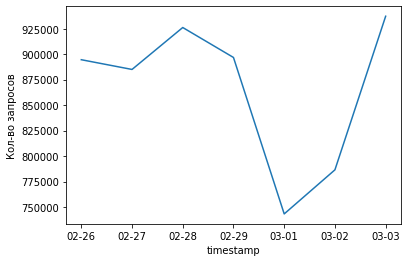

In [57]:
plt.xlabel('timestamp')
plt.ylabel('Кол-во запросов')
plt.plot(x_ts_label, df7['кол-во запросов'].values)
plt.show()

Количество запросов уменьшилось 1 и 2 марта по сравнению с другими днями, поэтому можно объяснить уменьшение количества кликов, однако вопрос о причине уменьшения кол-ва запросов остаётся открытым

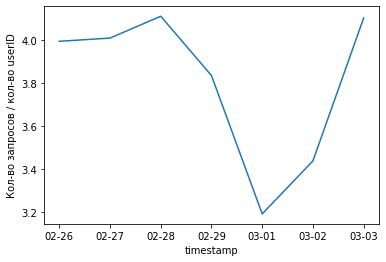

In [58]:
plt.xlabel('timestamp')
plt.ylabel('Кол-во запросов / кол-во userID')
plt.plot(x_ts_label, df7['кол-во запросов'].values / df6['кол-во userID'].values)
plt.show()

In [59]:
df8 = pd.DataFrame(columns=['ts', 'Доля некликнутых запросов'])
rowIdx = 0
for ts in timestamps:
    df8.loc[rowIdx] = [ts, len(data[(data['ts'] == ts) & (data['all_cl'] == 0)]) / len(data[data['ts'] == ts])]
    rowIdx += 1
df8

,ts,Доля некликнутых запросов
0,2016-02-26,0.400054
1,2016-02-27,0.393380
2,2016-02-28,0.386993
3,2016-02-29,0.505201
4,2016-03-01,0.662804
5,2016-03-02,0.357857
6,2016-03-03,0.396518


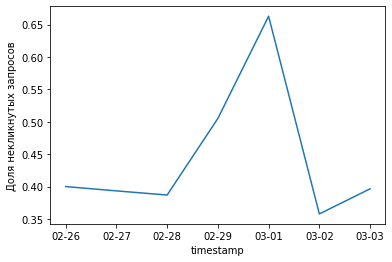

In [60]:
plt.xlabel('timestamp')
plt.ylabel('Доля некликнутых запросов')
plt.plot(x_ts_label, df8['Доля некликнутых запросов'].values)
plt.show()

Доля некликнутых запросов выросла и количество пользователей выросло. Скорее всего были добавлены быстрые ответы на серпе, поэтому возник большой спрос на "некликнутые запросы" и количество пользователей увеличилось засчет того, что они захотели попробовать новые возможности. В любом случае изменения помогли привлечь новых пользователей и увеличить долю некликнутых запросов. 

In [61]:
df9 = pd.DataFrame(columns=['ts', 'exp_cl', 'control_cl'])
rowIdx = 0
for ts in timestamps:
    exp = len(data[(data['ts'] == ts) & (data['slot'] == 'exp') & (data['all_cl'] == 0)]['all_cl'].values) / len(data[(data['ts'] == ts) & (data['slot'] == 'exp')])
    control = len(data[(data['ts'] == ts) & (data['slot'] == 'control') & (data['all_cl'] == 0)]['all_cl'].values) / len(data[(data['ts'] == ts) & (data['slot'] == 'control')])
    
    df9.loc[rowIdx] = [ts, exp, control]
    rowIdx += 1
df9

,ts,exp_cl,control_cl
0,2016-02-26,0.387944,0.411771
1,2016-02-27,0.380940,0.405412
2,2016-02-28,0.375698,0.397888
3,2016-02-29,0.493524,0.516502
4,2016-03-01,0.655728,0.669602
5,2016-03-02,0.344367,0.370888
6,2016-03-03,0.383243,0.409376


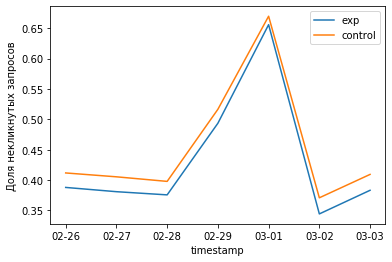

In [62]:
plt.xlabel('timestamp')
plt.ylabel('Доля некликнутых запросов')
plt.plot(x_ts_label, df9['exp_cl'].values, label='exp')
plt.plot(x_ts_label, df9['control_cl'].values, label='control')
plt.legend()
plt.show()

1. Количество кликов на эксперименте увеличилось  
2. Увеличилось количество пользователей
3. На эксперименте уменьшилась доля некликнутых запросов
4. Кол-во кликов изменилось в зависимости от использования браузера:
    - в браузере под номером 14 числов кликов увеличилось
    - во всех остальных либо уменьшилось, либо изменилось не так сильно
5. 1 марта наблюдается минимум по количеству запросов и максимум по доле некликнутых запросов. Число пользователей после этого уменьшилось, но по-прежнему было больше, чем в начале наблюдений.

Скорее всего изменения имели положительных эффект, так как увеличилось количество пользователей и в целом уменьшилось количество кликов в эксперименте, то есть поиск работает лучше. Однако стоит устранить недостатки в браузере 14, так как там количество кликов очень сильно увеличилось в эксперименте. Также, видимо, сервис работает не всегда корректно и нужно подправить баги. Однако прежде всего нужно сначала исследовать на дополнительных данных, почему просело количество запросов 1 марта. Было бы неплохо посмотреть на сами запросы: есть ли одинаковые запросы подряд и пользователь просто переформулирует свой вопрос, то есть не может найти подходящий ответ, и из-за этого доля некликнутых запросов резко увеличилась. Или же были введены мгновенные ответы (однако почему кол-во запросов упало??). Поэтому нужны дополнительные исследования, после которых ответ получится более полным.